In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os
import pandas as pd
import torch.nn.functional as F

from lib.utils import get_free_gpu, load_lizard, debug
from lib.utils_vis import make_seed, to_rgb
from lib.EnergyCAModel import EnergyCAModel
from lib.CAModel import CAModel
from lib.utils import animate_steps
model_dir = 'models/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialization


Getting free GPU...
| ID | GPU | MEM |
------------------
|  0 | 65% | 65% |
|  1 | 21% | 91% |
|  2 | 57% | 91% |
|  3 | 78% | 92% |
|  4 |  0% |  0% |
Using GPU:  4


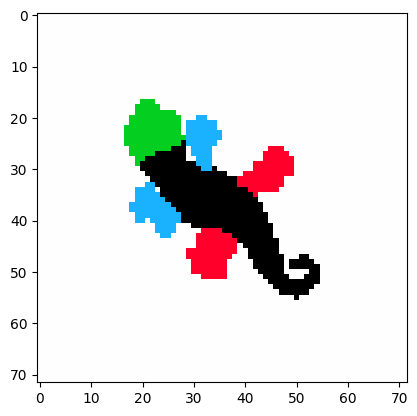

In [23]:

torch.backends.cudnn.benchmark = True # Speeds up stuff
torch.backends.cudnn.enabled = True

## General Parameters ##
global_params = {
    'CHANNEL_N': 16,
    'TARGET_PADDING': 16,
    'TARGET_SIZE': 40,
    'IMG_SIZE': 72,
    'MIN_STEPS': 64,
    'MAX_STEPS': 128,
}

## General Training Parameters ##
# choose cuda device with the least amount of current memory usage
training_params = {
    'lr': 2e-3,
    'lr_gamma': 0.9999,
    'betas': (0.5, 0.5),
    'n_epoch': 10000,
    'batch_size': 8,
    'grad_clip': 1.0,
    'device': torch.device('cuda:{}'.format(get_free_gpu()) if torch.cuda.is_available() else 'cpu'),
    'history_save_dir': 'histories/',
    'model_save_dir': 'models/gumbel/', ###
}

ca_params = {"CELL_FIRE_RATE": 0.5}
number_of_batches = 10#10

# Load target emoji
target_img = load_lizard('data/lizard_clean.png')
p = global_params['TARGET_PADDING']
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32))

# Load body parts emoji
parts_img = load_lizard('data/lizard_parts.png')
pad_parts = np.pad(parts_img, [(p, p), (p, p), (0, 0)])

# Create initial state
seed = make_seed((h, w), global_params['CHANNEL_N'])
x0 = np.repeat(seed[None, ...], training_params["batch_size"], 0)
x0 = torch.from_numpy(x0.astype(np.float32)).to(training_params['device'])

plt.imshow(to_rgb(pad_target.detach().cpu()[0]))
plt.imshow(pad_parts)

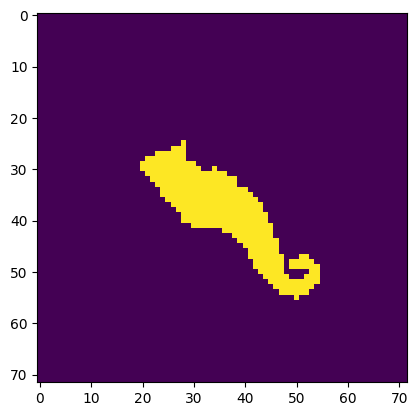

In [41]:
plt.imshow((pad_parts[:,:,3]==1) & (pad_parts[:,:,0]==0) & (pad_parts[:,:,1]==0) & (pad_parts[:,:,2]==0))